In [1]:
import numpy as np
import laspy
import open3d as o3d
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.neighbors import KDTree

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
intrinsic = np.array(
    [
        [1024, 0, 1024],
        [0, 1024, 1024],
        [0,    0,    1],
    ],
    dtype='float32'
)

extrinsic = np.array(
    [
        [-6.9262244e-02, -9.9737304e-01,  2.1206183e-02,  1.2928122e+05],
        [ 8.4582595e-03, -2.1843584e-02, -9.9972564e-01,  8.3126572e+03],
        [ 9.9756265e-01, -6.9063872e-02,  9.9489763e-03,  8.1891594e+05],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00],
    ],
    dtype='float32'
)
np.linalg.inv(extrinsic)[:3, 3]

array([-808035.94  ,  185680.69  ,   -2578.5596], dtype=float32)

In [13]:
pcd_path = r'D:\geo_ai_data\point_clouds\Run_5s2224605_20200609-091004_0005.las'

with laspy.open(pcd_path) as fh:
    las = fh.read()

points = np.stack([las.x, las.y, las.z], axis=0).T
colors = np.stack([las.red, las.green, las.blue], axis=0).T.astype('float64') / 65535

print(points.shape)
print(colors.max())

(104359397, 3)
0.9960936903944457


In [4]:
# Point cloud visualization
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd])

In [6]:
# Voxel downsampling
pcd = o3d.geometry.PointCloud()

pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

down_pcd = pcd.voxel_down_sample(voxel_size=0.5)

# np.save('down_pcd_points.npy', np.asarray(down_pcd.points))
# np.save('down_pcd_colors.npy', np.asarray(down_pcd.colors))
o3d.visualization.draw_geometries([down_pcd])

In [7]:
np.save('down_pcd_points_global.npy', np.asarray(down_pcd.points))
np.save('down_pcd_colors_global.npy', np.asarray(down_pcd.colors))

In [3]:
points = np.load('down_pcd_points_global.npy')
colors = np.load('down_pcd_colors_global.npy')

In [10]:
# watch pov
pov_car = np.array([[-837810.0000001723, 184720.00000067055, -4279.999999999973]])
pov_cam = np.array([[-808035.94  ,  185680.69  ,   -2578.5596]])
print(pov_cam - pov_car)

points_and_povs = np.concatenate([points, pov_car, pov_cam], axis=0).astype('float64')
colors = np.zeros(points_and_povs.shape, dtype=points_and_povs.dtype)

colors[:-2, 2] = 0.5
colors[-2, 0] = 1
colors[-2, 1] = 1
colors[-1, 0] = 1

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_and_povs)
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd])

[[29774.06000017   960.68999933  1701.4404    ]]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Требуемая операция преобразования не поддерживается. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Неверный дескриптор. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Требуемая операция преобразования не поддерживается. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Неверный дескриптор. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Неверный дескриптор. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Неверный дескриптор. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Требуемая операция преобразования не поддерживается. 


In [8]:
pcd = o3d.geometry.PointCloud()

#tree = KDTree(points, leaf_size=200*1000*1000)
radius = 1000*1000
ind = tree.query_radius(np.linalg.inv(extrinsic)[:3, 3:4].T, r=radius)  
print(ind)    
points2 = points[ind[0]] 

pcd.points = o3d.utility.Vector3dVector(points2)
o3d.visualization.draw_geometries([pcd])

[array([       0,        1,        2, ..., 78000433, 78000434, 78005854],
       dtype=int64)                                                      ]


In [9]:
# np.save('tree_1m_pcd_points.npy', points2)

In [29]:
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points)

# camera = np.linalg.inv(extrinsic)[:3, 3]
# radius = 10*1000*1000

# _, pt_map = pcd.hidden_point_removal(camera, radius)

# pcd_sel = pcd.select_by_index(pt_map)
# o3d.visualization.draw_geometries([pcd_sel])

In [10]:
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(100)

radii = [1000] * 4
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, o3d.utility.DoubleVector(radii))

# with o3d.utility.VerbosityContextManager(
#         o3d.utility.VerbosityLevel.Debug) as cm:
#     mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
#         pcd_sel, depth=9)
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

: 

: 

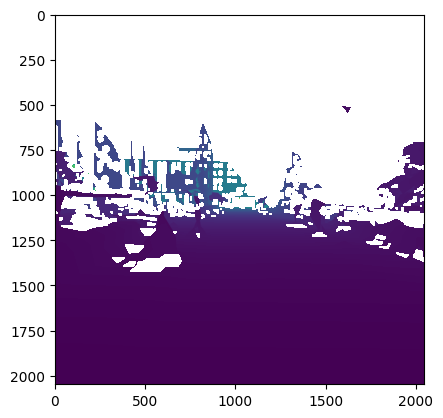

In [11]:
# Create a scene and add the triangle mesh
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))

rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    o3d.core.Tensor(intrinsic),
    o3d.core.Tensor(extrinsic),
    2048,
    2048,
)
# We can directly pass the rays tensor to the cast_rays function.
ans = scene.cast_rays(rays)
plt.imshow(ans['t_hit'].numpy())
plt.show()

In [2]:
pcd_path = r'D:\geo_ai_data\point_clouds\Run_5s2224605_20200609-091004_0005.las'

with laspy.open(pcd_path) as fh:
    las = fh.read()

points = np.stack([las.X, las.Y, las.Z], axis=0).T
colors = np.stack([las.red, las.green, las.blue], axis=0).T.astype('float64') / 65535

print(points.shape)
print(colors.max())

(104359397, 3)
0.9960936903944457


In [19]:
pcd = o3d.geometry.PointCloud()

points = np.load('down_pcd_points.npy')
colors = np.load('down_pcd_colors.npy')

pov = [-837810, 184720, -4279]
points[:, 0] -= pov[0]
points[:, 1] -= pov[1]
points[:, 2] -= pov[2]

print('points.shape', points.shape)
print('colors.shape', colors.shape)

pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

# hidden_point_removal
print("Define parameters used for hidden_point_removal")
camera = [0, 0, 0]
radius = 10*1000*1000

print("Get all points that are visible from given view point")
_, pt_map = pcd.hidden_point_removal(camera, radius)

print("Visualize result")
pcd_sel = pcd.select_by_index(pt_map)
o3d.visualization.draw_geometries([pcd_sel])



points.shape (346201, 3)
colors.shape (346201, 3)
Define parameters used for hidden_point_removal
Get all points that are visible from given view point
Visualize result
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Требуемая операция преобразования не поддерживается. 


In [4]:
points_3d_raw = np.array(
    [
        # [369500.609200, 2681843.513400, 236.947495],
        # [369500.368698, 2681843.383200, 245.0227695],
        # [369500.535103, 2681845.144300, 244.967697],
        # [369508.675102, 2681842.793700, 237.158096],
        # [369489.142403, 2681849.746500, 236.618500],
        # [369488.720299, 2681849.708099, 237.468704],
        # [369488.698601, 2681849.664101, 238.218704],
        
        # # 25 0
        # [369496.409896, 2681844.68500, 236.882797],
        # [369496.815804, 2681851.721800, 236.744003],
        # [369500.425301, 2681844.665100, 236.934296],
        # [369500.433403, 2681851.564800, 236.807404],
        
        # 25 2
        [369547.255402, 2681849.581800, 237.202698],
        [369553.496601, 2681842.011400, 237.262405],
        [369534.217400, 2681850.194901, 237.224701],
        [369540.766300, 2681842.732600, 237.303604],
    ]
)

# print('las.points.offsets', las.points.offsets)
# print('las.points.scales', las.points.scales)

offsets = [3.69600e+05, 2.68183e+06, 2.40000e+02]
scales = [0.0001, 0.0001, 0.0001]
lidar_points_of_view = (points_3d_raw - offsets) / scales
lidar_points_of_view = lidar_points_of_view.astype(np.int32)
lidar_points_of_view

array([[-527445,  195817,  -27973],
       [-465033,  120114,  -27375],
       [-657825,  201949,  -27752],
       [-592336,  127326,  -26963]])

In [3]:
pcd = o3d.geometry.PointCloud()

pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

down_pcd = pcd.voxel_down_sample(voxel_size=5000)

np.save('down_pcd_points.npy', np.asarray(down_pcd.points))
np.save('down_pcd_colors.npy', np.asarray(down_pcd.colors))
#o3d.visualization.draw_geometries([down_pcd])

In [ ]:
print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(down_pcd,
                                                            voxel_size=5000)
o3d.visualization.draw_geometries([voxel_grid])

In [4]:
pov = [-837810, 184720, -4279]
trans = np.array(
    [
        [1, 0, 0, -pov[0]],
        [0, 1, 0, -pov[1]],
        [0, 0, 1, -pov[2]],
        [0, 0, 0, 1      ],
    ],
    dtype='float32'
) 

rot = np.array(
    [
        [0,  0, 1, 0],
        [0,  1, 0, 0],
        [-1, 0, 0, 0],
        [0,  0, 0, 1],
    ],
    dtype='float32'
) 

h = rot @ trans
h
# point_data[:, 0] -= pov[0]
# point_data[:, 1] -= pov[1]
# point_data[:, 2] -= pov[2]

array([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  4.2790e+03],
       [ 0.0000e+00,  1.0000e+00,  0.0000e+00, -1.8472e+05],
       [-1.0000e+00,  0.0000e+00,  0.0000e+00, -8.3781e+05],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
      dtype=float32)

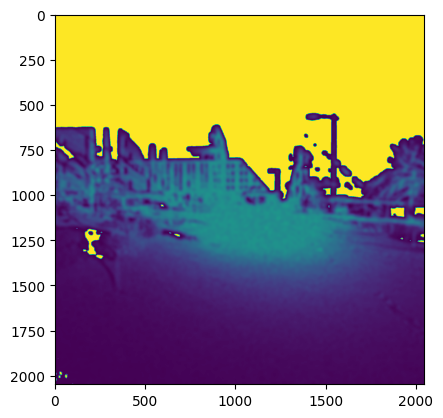

In [21]:
intrinsic = o3d.core.Tensor([[1024.0, 0, 1024.0], [0, 1024.0, 1024.0], [0, 0, 1]])
extrinsic = o3d.core.Tensor(np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ np.array([[0, -1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]))
pcd_t = o3d.t.geometry.PointCloud()

#o3d.visualization.draw_geometries([down_pcd])
points = np.asarray(pcd.points).astype('float32')
pov = [-837810, 184720, -4279]
points[:, 0] -= pov[0]
points[:, 1] -= pov[1]
points[:, 2] -= pov[2]

points /= 200000
pcd_t.point.positions = o3d.core.Tensor(points)
depth_reproj = pcd_t.project_to_depth_image(2048, 2048, intrinsic, extrinsic, depth_scale=5000.0, depth_max=10.0)

depth_reproj = np.asarray(depth_reproj)
depth_reproj *= 255
depth_reproj = depth_reproj.astype('uint8')
depth_reproj = cv2.GaussianBlur(depth_reproj, (31, 31), 9)

ret, mask = cv2.threshold(depth_reproj, 1, 255, cv2.THRESH_BINARY_INV)
# print(depth_reproj)
plt.imshow(cv2.add(mask, depth_reproj))
#plt.imshow(depth_reproj)
plt.show()

In [4]:
tree = KDTree(point_data, leaf_size=200*1000*1000)
radius = 400*1000
ind = tree.query_radius(np.array([[0, 0, 0]]), r=radius)  
print(ind)     

In [5]:
rov = 400*1000
ind = tree.query_radius(np.array([[0, 0, 0]]), r=rov)  
print(ind)

[array([    1151,     1152,     1153, ..., 20213536, 20213537, 20216536],
       dtype=int64)                                                      ]


In [6]:
points = point_data[ind[0]]
colors = (points / (2*400*1000) + 0.5).astype('float64')

print(points.shape)
print(colors.shape, colors.max(), colors.min())

(11172171, 3)
(11172171, 3) 0.9997775 0.0002949999999999897


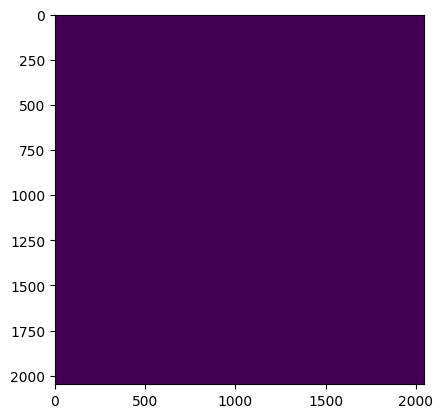

In [29]:
point_cloud = o3d.t.geometry.PointCloud()


point_cloud.point.positions = o3d.core.Tensor(points.astype('float32'))
downpcd = point_cloud.voxel_down_sample(5000)
# # o3d.visualization.draw([downpcd])
intrinsic = o3d.core.Tensor([[1024.0, 0, 1024.0], [0, 1024.0, 1024.0], [0, 0, 1]])
depth_reproj = downpcd.project_to_depth_image(2048,
                                              2048,
                                              intrinsic)
depth_reproj = np.asarray(depth_reproj)
depth_reproj
plt.imshow(depth_reproj)
plt.show()
# point_cloud.points = o3d.utility.Vector3dVector(points)
# point_cloud.colors = o3d.utility.Vector3dVector(colors)

# o3d.visualization.draw_geometries([point_cloud])


In [31]:
depth_reproj.max()

0.0

In [9]:
downpcd = point_cloud.voxel_down_sample(voxel_size=5000)
o3d.visualization.draw_geometries([downpcd])

In [10]:
intrinsic = o3d.core.Tensor([[535.4, 0, 320.1], [0, 539.2, 247.6], [0, 0, 1]])
depth_reproj = downpcd.project_to_depth_image(640,
                                              480,
                                              intrinsic)


AttributeError: 'open3d.cpu.pybind.geometry.PointCloud' object has no attribute 'project_to_depth_image'

TypeError: 'AxesSubplot' object is not subscriptable

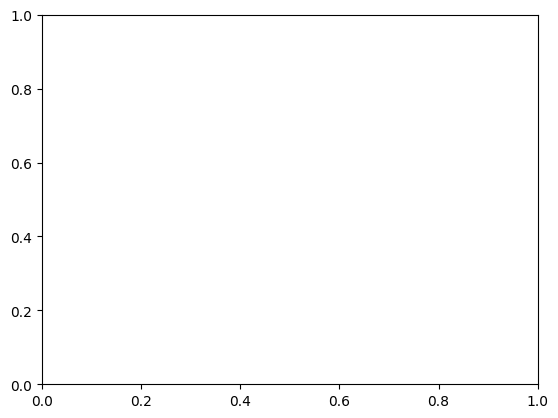

In [21]:
fig, axs = plt.subplots(1, 1)
axs[0].imshow(np.asarray(depth_reproj.to_legacy()))
plt.show()

In [30]:
def cart2sph(points: np.ndarray) -> np.ndarray:
    """Converts a cartesian coordinate (x, y, z) into a spherical one (radius, theta, phi)."""
    points = points.astype('float64')
    x, y, z = points[:, 0], points[:, 1], points[:, 2]  
    radius = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(np.sqrt(x*x + y*y), z)
    phi = np.arctan2(y, x)
    
    return np.concatenate([[radius], [theta], [phi]], axis=0).T

In [38]:
sph_points = cart2sph(points)
sph_points[:20]

array([[3.71134929e+05, 1.11367694e+00, 1.43688280e+00],
       [3.69900484e+05, 1.11505077e+00, 1.43663068e+00],
       [3.68323407e+05, 1.11673991e+00, 1.43592077e+00],
       [3.67107108e+05, 1.11810502e+00, 1.43561977e+00],
       [3.65732408e+05, 1.11969678e+00, 1.43544088e+00],
       [3.64583717e+05, 1.12102889e+00, 1.43525654e+00],
       [3.63239323e+05, 1.12261340e+00, 1.43509981e+00],
       [3.61946108e+05, 1.12420573e+00, 1.43522985e+00],
       [3.60875083e+05, 1.12568741e+00, 1.43606521e+00],
       [3.60391375e+05, 1.12729385e+00, 1.44086188e+00],
       [3.60064506e+05, 1.12876841e+00, 1.44584680e+00],
       [3.59672910e+05, 1.13033498e+00, 1.45078903e+00],
       [3.59309654e+05, 1.13202691e+00, 1.45634447e+00],
       [3.58940553e+05, 1.13360569e+00, 1.46124722e+00],
       [3.58415427e+05, 1.13535014e+00, 1.46594194e+00],
       [3.58163848e+05, 1.13688891e+00, 1.47112767e+00],
       [3.57854330e+05, 1.13849560e+00, 1.47618352e+00],
       [3.57440065e+05, 1.14044

In [39]:
pano_points = sph_points.copy()
pano_points[:, 0] *= 255 / (200*1000)
pano_points[:, 1] *= 4000 / np.pi
pano_points[:, 2] *= 4000 / np.pi
pano_points = pano_points.astype('int32')
pano_points

array([[ 473, 1417, 1829],
       [ 471, 1419, 1829],
       [ 469, 1421, 1828],
       ...,
       [ 504, 1998, 1262],
       [ 509, 1997, 1458],
       [ 509, 1997, 1459]])

In [43]:
pano_points[:, 1].max()

3998

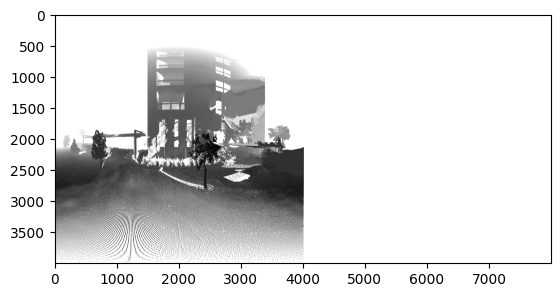

In [46]:
img = np.ones((4000, 8000), dtype='uint8') * 255
for pt in pano_points:
    r, theta, phi = pt
    cv2.circle(img, (phi, theta), 5, int(min(img[theta, phi], r)))
    # img[theta, phi] = min(img[theta, phi], r)

plt.imshow(img, 'gray')
plt.show()
    

In [47]:
del pano_points

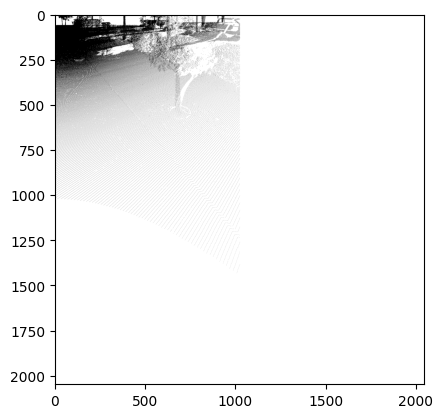

In [48]:
img = np.ones((2048, 2048), dtype='uint8') * 255

c_phi = 0
c_theta = np.pi / 2
delta_phi = np.pi / 4
delta_theta = np.pi / 4
f = 1024

for pt in sph_points:
    r, theta, phi = pt

    if phi < c_phi - delta_phi or phi > c_phi + delta_phi:
        continue
    if theta < c_theta - delta_theta or theta > c_theta + delta_theta:
        continue
    
    x = int(f * np.tan(phi - c_phi))
    y = int(f / np.cos(phi - c_phi) * np.tan(theta - c_theta))
    
    color = r // (400*1000)
    if color > img[y][x]:
        continue
    
    cv2.circle(img, (x, y), int(100 / r), color, -1)
    # img[theta, phi] = min(img[theta, phi], r)

plt.imshow(img, 'gray')
plt.show()
